In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

In [4]:
from keras import backend as K
from keras.models import Model, Input, load_model
from keras.layers import Input, Dense, Embedding, BatchNormalization, \
                Concatenate, LSTM, Lambda,  Activation, \
                Conv1D, MaxPooling1D, Flatten, Reshape, Dropout, CuDNNGRU, Bidirectional, CuDNNLSTM, LSTM
from keras.optimizers import RMSprop, Adam, Adamax, SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from keras.layers.merge import add
from keras.utils import to_categorical

Using TensorFlow backend.


In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score as scikit_f1_score

#### Custom Functions

In [6]:
from src.callbacks import PlotCurves
from src.eval_metrics import f1_macro, f1_micro 
from src.load_data import load_data

In [7]:
from src.keras_attention import AttentionWithContext

In [8]:
from src.tfselfattention import SelfAttention 

### Load Data

In [9]:
train_data, valid_data, test_data, metadata = load_data()

### Prepare data

In [10]:
n_tags = 2
batch_size = 32

In [11]:
def get_input(data_, one_hot=False):

    X = np.array([sentence['sentence'].replace('\n', '').strip()
                  for article in data_
                  for sentence in article['sentences']])

    y = np.array([sentence['label']
                  for article in data_
                  for sentence in article['sentences']])

    if one_hot:
        y = to_categorical(y, num_classes=2)

    return X, y

In [12]:
X_tra, y_tra = get_input(train_data, one_hot=True)
X_val, y_val = get_input(valid_data, one_hot=True)
X_test, y_test = get_input(test_data, one_hot=False)

In [13]:
X_tra.shape, y_tra.shape, X_test.shape, y_test.shape

((3582,), (3582, 2), (441,), (441,))

### Load ELMo

In [14]:
sess = tf.Session()
K.set_session(sess)

os.environ["TFHUB_CACHE_DIR"] = '/tmp/tfhub'

elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)

### Build Model

In [16]:
def ELMoEmbedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["elmo"]

In [24]:
def build_model_0():

    input_text = Input(shape=(None, ), dtype='string')
    embedding = Lambda(ELMoEmbedding, output_shape=(None, 1024))(input_text)
    
#     x = Bidirectional(CuDNNLSTM(256, return_sequences=True))(embedding)

    embedded, attention_weights = SelfAttention(size=1024,
                                                num_hops=6,
                                                use_penalization=False)(embedding)
    
    x = Flatten()(embedded)

    x = Dense(512)(x)#, kernel_regularizer=l2(0.001))(x)
    x = Activation('relu')(x)

    x = Dense(256)(x)#, kernel_regularizer=l2(0.001))(x)
    x = Activation('relu')(x)

    pred = Dense(2, activation='softmax')(x)

    return Model(inputs=[input_text], outputs=pred)

In [25]:
learningrate=0.001
optimizer = Adam(lr=learningrate)
optimizer_str = 'adam'
loss = 'binary_crossentropy'
metrics = ['acc', f1_macro, f1_micro]

In [26]:
model = build_model_0()
model.summary()

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

TypeError: Failed to convert object of type <class 'tuple'> to Tensor. Contents: (1024, Dimension(1024)). Consider casting elements to a supported type.

In [25]:
model_name = 'RQ2_elmo_attention_model_104' + \
             '_' + optimizer_str +  \
             '_lr_' + str(learningrate) +  \
             '_lrreduction' + \
             '_loss_' + loss

model_main = './Model/' + model_name.split('model')[0] + 'model/'
model_dir = os.path.join(model_main, model_name)
score_file = os.path.join(model_main, 'model_performances.csv')
results_file = os.path.join(model_dir, 'model_results_file.txt')

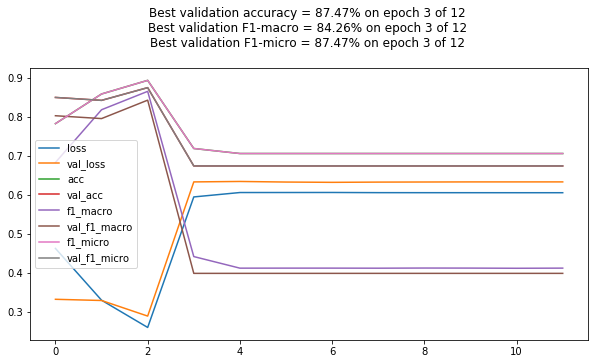

Epoch 13/50
 512/3582 [===>..........................] - ETA: 15s - loss: 0.5725 - acc: 0.7441 - f1_macro: 0.4260 - f1_micro: 0.7441

KeyboardInterrupt: 

In [26]:
model.fit(X_tra, y_tra, 
          epochs=50, 
          batch_size=batch_size, 
          validation_data=(X_val, y_val), 
          callbacks=[
              PlotCurves(model_name=model_name, model_dir=model_dir, jnote=True),
              ReduceLROnPlateau(monitor='val_f1_macro', patience=3, 
                                factor=0.1, min_lr=0.00001),
              EarlyStopping(monitor='val_f1_macro', min_delta=0, patience=10, mode='max')
          ])

#### Load Best Model

In [36]:
model_name

'RQ2_elmo_attention_model_104_adam_lr_0.0001_lrreduction_loss_binary_crossentropy'

In [38]:
best_model = load_model(os.path.join(model_dir, model_name + '_best_f1_macro_model.h5'), 
                        custom_objects={'elmo':elmo, 'tf':tf, 'f1_macro':f1_macro, 'f1_micro':f1_micro,
                                       'AttentionWithContext': AttentionWithContext})

### Evaluation

In [13]:
def get_scores(model, data_, batch_size, results_file, print_out=False):

    X, y_true = get_input(data_, one_hot=False)

    y_preds = model.predict(X, batch_size=batch_size)
    y_preds = np.argmax(y_preds, axis=1)

    clsrpt = classification_report(y_true, y_preds)
    sf1 = scikit_f1_score(y_true, y_preds)
    sfm = scikit_f1_score(y_true, y_preds, average='macro')

    if print_out:
        print(clsrpt)
        print('\nScikit_F1_Macro:', sfm)
        print('\nScikit_F1_1:', sf1)

    if results_file:
        with open(results_file, 'a') as f:
            f.write('\n' + clsrpt + '\nF1_Macro: ' + str(sfm) + '\nF1_1: ' + str(sf1) + '\n\n')

    return sfm

In [ ]:
with open(results_file, 'w') as f:
    f.write('\n---------------- Validation ----------------\n')

val_f1 = get_scores(best_model, valid_data, batch_size, results_file)

In [ ]:
with open(results_file, 'a') as f:
    f.write('\n---------------- Test ----------------\n')

test_f1 = get_scores(best_model, test_data, batch_size, results_file)

### Old results

In [39]:
#[x_val_words, x_val_sentences]
y_preds = best_model.predict(X_val, batch_size=batch_size)
y_preds = np.argmax(y_preds, axis=1)

In [40]:
y_val = np.argmax(y_val, axis=1)

In [41]:
clsrpt_val = classification_report(y_val, y_preds)
sfm_val = scikit_f1_score(y_val, y_preds, average='macro')
    
print(clsrpt_val)
print('\nScikit_F1_Macro:', sfm_val)

with open(results_file, 'w') as f:
    f.write('\n---------------- Validation ----------------\n')

with open(results_file, 'a') as f:
    f.write('\n' + clsrpt_val + '\n' + str(sfm_val) + '\n\n')

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       269
           1       0.81      0.80      0.81       130

   micro avg       0.87      0.87      0.87       399
   macro avg       0.86      0.86      0.86       399
weighted avg       0.87      0.87      0.87       399


Scikit_F1_Macro: 0.8568044788975021


In [42]:
# X, y = get_input(data_, n_tags, True)
# [x_test_words, x_test_sentences]
y_preds = best_model.predict(X_test, batch_size=batch_size)
y_preds = np.argmax(y_preds, axis=1)

In [43]:
clsrpt_test = classification_report(y_test, y_preds)
sfm_test = scikit_f1_score(y_test, y_preds, average='macro')
    
print(clsrpt_test)
print('\nScikit_F1_Macro:', sfm_test)

with open(results_file, 'a') as f:
    f.write('\n---------------- Test ----------------\n')

with open(results_file, 'a') as f:
    f.write('\n' + clsrpt_test + '\n' + str(sfm_test) + '\n\n')

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       325
           1       0.74      0.57      0.64       116

   micro avg       0.83      0.83      0.83       441
   macro avg       0.80      0.75      0.77       441
weighted avg       0.83      0.83      0.83       441


Scikit_F1_Macro: 0.768036891594913


In [44]:
if not os.path.exists(score_file):
    with open(score_file, 'w') as scrf:
        scrf.write("model_name,val_f1_macro,test_f1_macro\n")

with open(score_file, 'a') as scrf:
    scrf.write(
        '\n' + \
        model_name + ',' + \
        str(sfm_val) + ',' + \
        str(sfm_test) + '\n'
    )